In [9]:
import pandas as pd
import numpy as np

from scipy.fft import fft, fftfreq, ifft, fft2, ifft2, ifftshift
from scipy.signal import blackman
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.signal import butter
from scipy import signal
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
from scipy.ndimage import gaussian_filter as gf

from xrdc import featurization as feat
from xrdc import fourier

#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

In [4]:
from xrdc import source_separation as sep
from xrdc import featurization as feat

In [5]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = (patterns.values.T)[:, 1:]

for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
#patterns = np.vstack((patterns[0][None, :], patterns))

In [144]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7,
                                                    background_after_filter = False)

(0, 0)


In [145]:
from importlib import reload
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

Peak at 69, start iteration with error = 0.5832013032160881
Peak at 69, iteration 0: error = 322.4903307414707
Peak at 68, start iteration with error = 0.6126506412724262
Peak at 68, iteration 0: error = 266.5609044939182
Peak at 276, start iteration with error = 0.5759595785118747
Peak at 276, iteration 0: error = 250.91300196711111
Peak at 276, start iteration with error = 0.5857118678270243
Peak at 276, iteration 0: error = 344.6914745627006
Peak at 210, start iteration with error = 0.6255641065190974
Peak at 210, iteration 0: error = 332.5207780154602
Peak at 207, start iteration with error = 0.5589257330354117
Peak at 207, iteration 0: error = 338.90814688037307
26
8.182289029821732


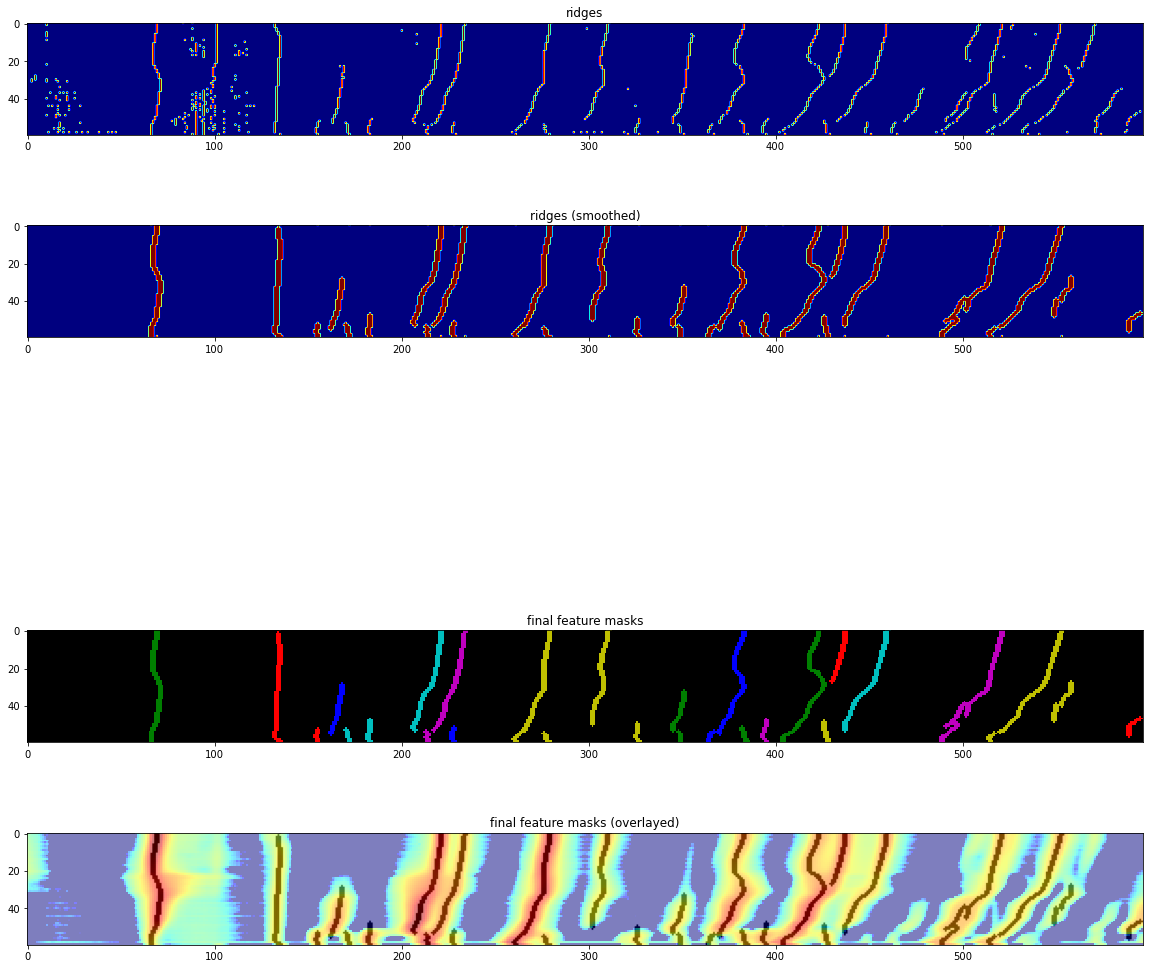

In [146]:
def default_featurize(patterns_pp):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 1, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    return labeled, feature_masks, activations, norm_, activations_n1


patterns_pp = fast_q * (fast_q > 0)
labeled, feature_masks, activations, _norm, activations_n1 = default_featurize(patterns_pp);

In [147]:
# remove infs 
featmask = ~np.isinf(activations_n1).any(axis = 1)
activations_n1 = activations_n1[featmask]

def norm(arr):
    na = _norm(arr)
    na = na[featmask]
    return na

In [148]:
activations_noise = feat.featurize(feature_masks, fast_T)
# activations_noise = feat.featurize(feature_masks, np.percentile(np.abs(fast_T.T), 68) * np.ones_like(fast_T.T))

do_norm = True

uncertainty = np.abs((norm(activations + activations_noise) - norm(activations)))

-8034.938277645266
8.182289029821732


In [158]:
a, b = 2, 3
#plt.rcParams["figure.figsize"]=(20, 15)
plt.rcParams["figure.figsize"]=(12,8)

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:200: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(composition, composition.T) / np.outer(norm, norm)
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:208: RuntimeWarning: invalid value encountered in subtract
  dist_l2 = np.sqrt(np.einsum("ijk, ijk->ij", a - b, a - b))


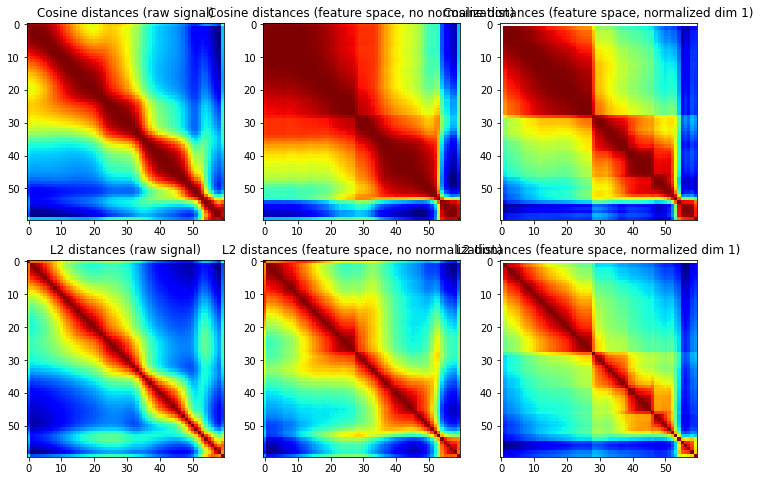

In [141]:


feat.similarity_plot_row(feat.csim_pairs, 'Cosine', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed,
                        a = a, b = b)
feat.similarity_plot_row(lambda arr: -feat.l2_pairs(arr), 'L2', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed, offset = 3,
                        a = a, b = b)

In [149]:
def cosine_error(arr, error):
    norm = np.linalg.norm(arr, axis = 1)
    
    errorA = np.dot(arr, error.T) / np.outer(norm, norm)
    errorB = np.dot(error, arr.T) / np.outer(norm, norm)

    qsum = np.sqrt(errorA**2 + errorB**2)

In [162]:
arr, error = activations_n1.T, uncertainty.T

norm = np.linalg.norm(arr, axis = 1)

errorA = np.dot(arr, error.T) / np.outer(norm, norm)
errorB = np.dot(error, arr.T) / np.outer(norm, norm)

qsum = np.sqrt(errorA**2 + errorB**2)

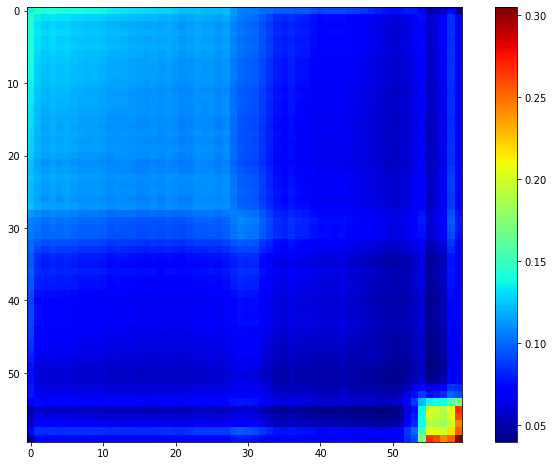

In [163]:
plt.imshow(qsum, cmap = 'jet')#, vmax = .2)
plt.colorbar()

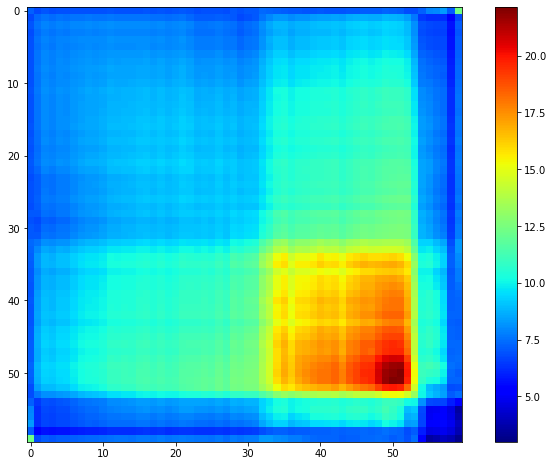

In [166]:
plt.imshow(feat.csim_pairs(activations_n1.T) / qsum, cmap = 'jet', vmin = 3)
plt.colorbar()

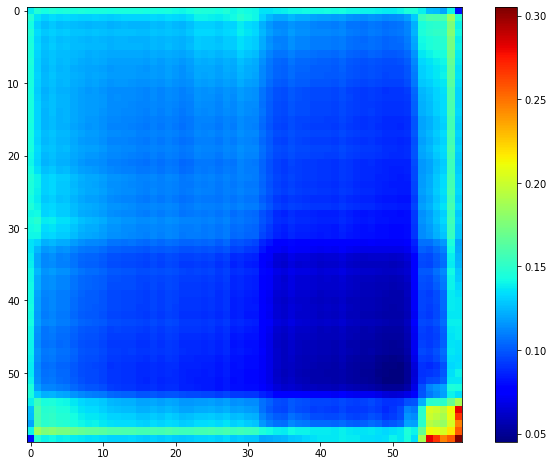

In [168]:
plt.imshow(qsum / feat.csim_pairs(activations_n1.T) , cmap = 'jet')
plt.colorbar()

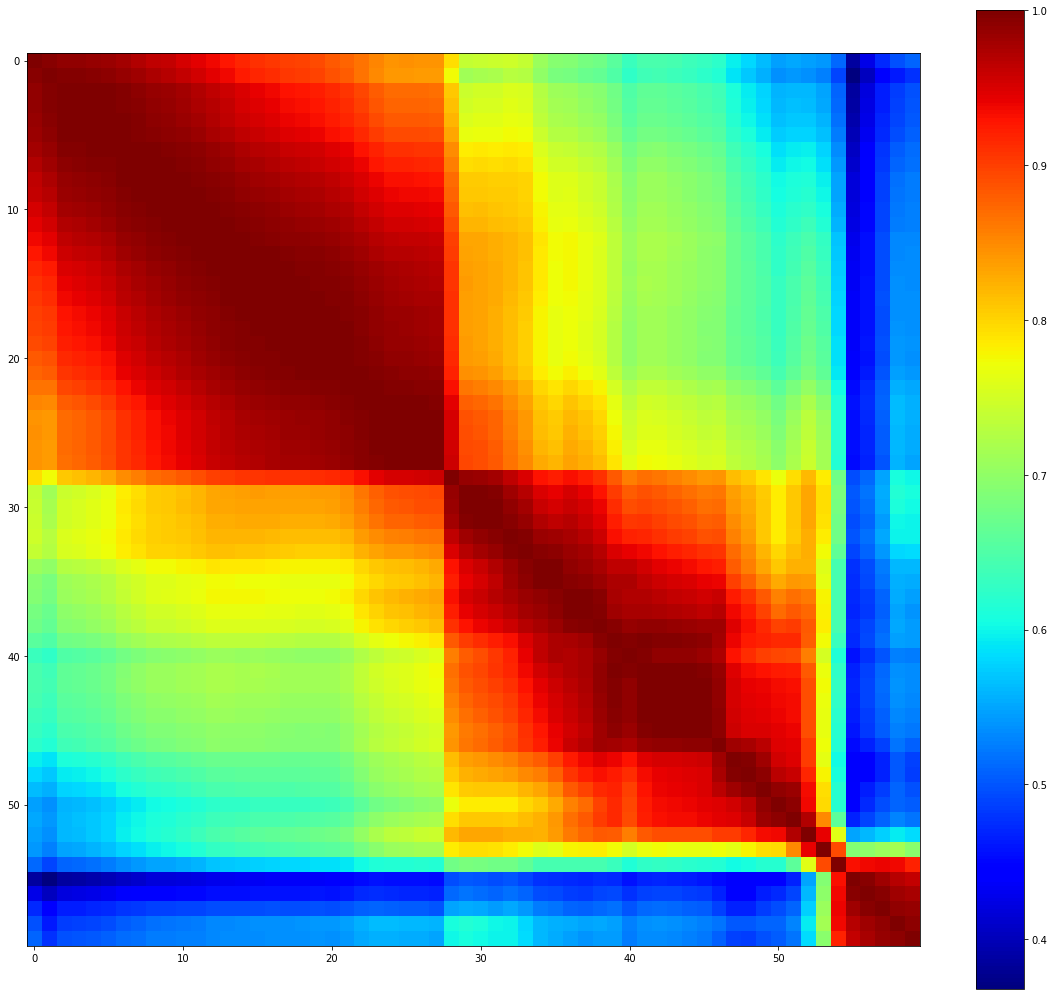

In [152]:
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar()